In [1]:
# this script plots the parameters sampling, and the outputs together with the reference data

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

#homemade function file
import importlib
import ppe_loading_functions #as functions
importlib.reload(ppe_loading_functions)
import ref_data_functions #as functions
importlib.reload(ref_data_functions)

from pylab import cm
import netCDF4
import numpy as np
from netCDF4 import Dataset

#HM
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
import random

In [2]:
var1stPPE, results1stPPE,var2ndPPE, results2ndPPE, varMoreCloudParam, resultsMoreCloudParam,\
 varMoreCloudParam2, resultsMoreCloudParam2, varPhyDyn_NewParam_2tun,resultsPhyDyn_NewParam_2tun,\
 varPhyDyn_NewParam_5thPPE_2tun,results_5thPPE_2tun=\
ppe_loading_functions.load_all_ppes()

In [3]:
#Ref tuned ICON-A 2.6.4
pressure_addi,pressure_fact,tauufact,aes_glo_psl,aes_SOO_tauu,aes_NAO_tauu,aes_60N_1000hPa_ua,aes_60S_1000hPa_ua,\
aes_60N_10hPa_ua,aes_60S_10hPa_ua=ref_data_functions.ICON_aes_refdata()


In [4]:
#Physics Ref
ref_mean, ref_std=ref_data_functions.References_outputs()
#Dynamics Ref
refsERA5, refsMERRA2, refsERAInterim=ref_data_functions.References_Dynoutputs()

#all ref values for Physics and Dynamic variables
ref2tun_mean=np.zeros(9)
ref2tun_mean[0:5]=ref_mean #physics variables
ref2tun_mean[5:]=[refsERA5[0],refsERA5[1],refsERA5[2],refsERA5[3]] #dynamics variables
#ref_mean
print(ref2tun_mean)

#all std for Physics and Dynamic variables: not used yet in the HM flow

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

[ 2.40866470e+02 -2.40114889e+02  5.00000000e-01  6.74343643e+01
  2.44086728e+01  1.09413767e+01  3.27732849e+01  2.94719753e-03
  1.36748120e-01]


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [5]:
ref_Clt_ESACCI, ref_Clt_ESACCI_std, ref_Clt_CLARA_AVHRR, ref_Clt_CLARA_AVHRR_std=ref_data_functions.Ref_clt()
ref_Prw_ESACCI, ref_Prw_ERA5, ref_Prw_ERA5_std=ref_data_functions.Ref_prw()

In [6]:
indHighCl=np.where(resultsPhyDyn_NewParam_2tun[:,3]>61.92)[0]
indHighClHighSW=np.where(resultsPhyDyn_NewParam_2tun[indHighCl,0]>240)[0]
indHighClHighSWGighLW=np.where(-resultsPhyDyn_NewParam_2tun[indHighCl[indHighClHighSW],1]>238)[0]
indplot=indHighCl[indHighClHighSW[indHighClHighSWGighLW]]
indplot

array([ 4, 11, 31])

In [7]:
years_clt_esacci,clt_esacci_per_year=ref_data_functions.clt_esacci_per_years()
years_clt_claraavhrr,clt_claraavhrr_per_year=ref_data_functions.clt_claraavhrr_per_years()
years_prw_era5,prw_era5_per_year=ref_data_functions.prw_era5_per_years()

In [8]:
name1stPPEini=r'ICON-A $PPE_1$'
name2ndPPEini=r'ICON-A $PPE_2$'
name1stPPEmore=r'ICON-A $PPE_3$'
name2ndPPEmore=r'ICON-A $PPE_4$'
selectedrun='selected run'

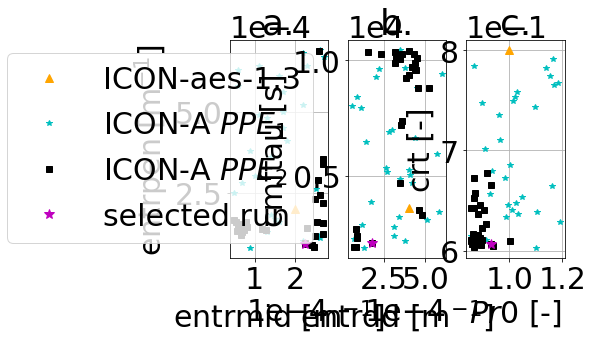

In [9]:
#plots of parameter ranges
#1st and 2nd PPE

#plot of all the data in the LHC ensemble
#initial bounds
iEmid_bounds = [1e-4, 2e-4]
iEpen_bounds = [1e-4, 4e-4]
iEdd_bounds = [2e-4, 4e-4]
iTaumf_bounds = [3600, 7200]
iPr_bounds = [8e-1, 1]
iR0top_bounds = [7e-1, 8e-1]
#initial bounds
ibounds=[iEmid_bounds, iEpen_bounds, iEdd_bounds, iTaumf_bounds, iPr_bounds, iR0top_bounds]

labelssave=['Emid','Epen','Edd','Taumf', 'Pr', 'R0top']

labels=[r'entrmid [m$^{-1}$]',r'entrpen [m$^{-1}$]',r'entrdd [m$^{-1}$]',r'cmftau [s]', r'$Pr0$ [-]', r'crt [-]']
labelsNounits=[r'$\epsilon_{mid}$',r'$\epsilon_{pen}$',r'$\epsilon_{dd}$',r'$\tau_{mf}$', r'$Pr$', r'$r_{0,top}$']
titles=['a.','b.','c.']
Giorgetta2018=[0.0002,0.0002,0.0004,3600,1,0.8]
nvar=6


fig = plt.figure()
fontSize=30
plt.rc('font', size=fontSize) 
plt.rcParams["axes.labelsize"] = fontSize
plt.rcParams['figure.figsize'] = [30, 8]
iplot=1
for p1 in [0,2,4]:
    
    ax = fig.add_subplot(1,3,iplot)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    p2=p1+1
    plt.plot([Giorgetta2018[p1]],[Giorgetta2018[p2]], '^',ms=8,color='orange',label='ICON-aes-1.3')
    plt.plot(var1stPPE[:,p1],var1stPPE[:,p2],'*c',label=name1stPPEini)
    plt.plot(var2ndPPE[:,p1],var2ndPPE[:,p2],'sk',label=name2ndPPEini)
    plt.plot(var2ndPPE[0,p1],var2ndPPE[0,p2],'*m',ms=10,label=selectedrun)
    
    plt.title(titles[iplot-1])
    plt.xlabel(labels[p1])
    plt.ylabel(labels[p2])

    if p1==0:
        plt.legend()
    plt.grid()
    iplot+=1

#fig.savefig('PaperFig/PPE_1st-2nd-paramSampling.png')


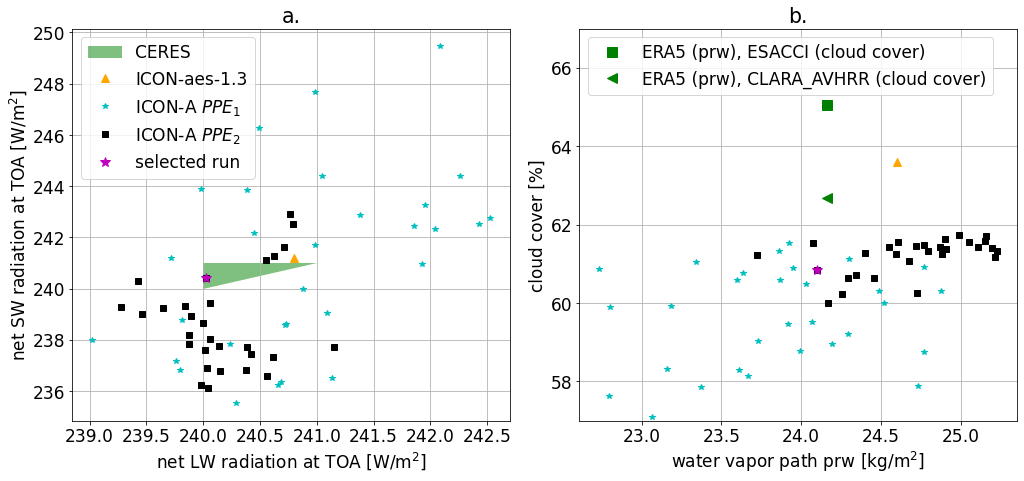

In [11]:
#Plot all Physics outputs against the Physics outputs 

cmap=plt.get_cmap("gist_rainbow")


#results=results_2ndPPE
minrad=240
maxrad=241
trianglex = [ minrad, minrad, maxrad, minrad ]  
triangley = [ minrad, maxrad, maxrad, minrad ]  
Nsel=0 #25, 23, 0,9
labelsoutputs=[r'net SW radiation at TOA [W/m$^2$]',r'outgoing LW radiation at TOA [W/m$^2$]',r'net radiation at TOA [W/m$^2$]',r'cloud cover [%]',r'water vapor path prw [kg/m$^2$]', r'global pressure at sea level [hPa]',\
                                r'tauu NAO [N/m$^2$]', r'tauu SOO [N/m$^2$]',r'ua 60N 1000hPa [m/s]',r'ua 60S 1000hPa [m/s]', r'ua 60N 10hPa [m/s]', r'ua 60S 10hPa [m/s]']
labelsoutputsnodim=[r'net SW radiation at TOA',r'outgoing LW radiation at TOA',r'Radiative budget at TOA ',r'cloud cover',r'water vapor path prw ', r'global pressure at sea level',\
                                r'tauu NAO', r'tauu SOO',r'ua 60N 1000hPa',r'ua 60S 1000hPa', r'ua 60N 10hPa', r'ua 60S 10hPa']
FirstpartTitle='ICON PPE results,'

Ntotparam=3
fig = plt.figure()
fontSize=17
plt.rc('font', size=fontSize) 
plt.rcParams["axes.labelsize"] = fontSize
plt.rcParams['figure.figsize'] = [15,7]
ax = fig.add_subplot(1,2,1)

plt.fill(trianglex, triangley,'g',alpha=0.5,label='CERES')
plt.plot([240.8], [241.2], '^',ms=8,color='orange',label='ICON-aes-1.3')
plt.plot(-results1stPPE[:,1],results1stPPE[:,0],'*c',label=name1stPPEini)
plt.plot(-results2ndPPE[:,1],results2ndPPE[:,0],'sk',label=name2ndPPEini)
plt.plot(-results2ndPPE[Nsel,1],results2ndPPE[Nsel,0],'*m',ms=10,label=selectedrun)

n=np.size(resultsPhyDyn_NewParam_2tun[:,1])
ax.set_title('a.')
ax.set_xlabel(r'net LW radiation at TOA [W/m$^2$]')
ax.set_ylabel(r'net SW radiation at TOA [W/m$^2$]')
ax.legend(loc="best")
ax.grid()

ax = fig.add_subplot(1,2,2)
plt.plot([24.6], [63.6], '^',ms=8,color='orange')
plt.plot(results1stPPE[:,4],results1stPPE[:,3],'*c')
plt.plot(results2ndPPE[:,4],results2ndPPE[:,3],'sk')
plt.plot(results2ndPPE[Nsel,4],results2ndPPE[Nsel,3],'*m',ms=10)
plt.plot(ref_Prw_ERA5,ref_Clt_ESACCI,'sg',ms=10,label='ERA5 (prw), ESACCI (cloud cover)')
plt.plot(ref_Prw_ERA5,ref_Clt_CLARA_AVHRR,'<g',ms=10,label='ERA5 (prw), CLARA_AVHRR (cloud cover)')

ax.set_title('b.')
ax.set_xlabel(r'water vapor path prw [kg/m$^2$]')
ax.set_ylabel('cloud cover [%]')
ax.legend(loc="upper left")
ax.set_ylim([57,67])

ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig('PaperFig/Paper_PhyOutputs_IniPhyParam.png')

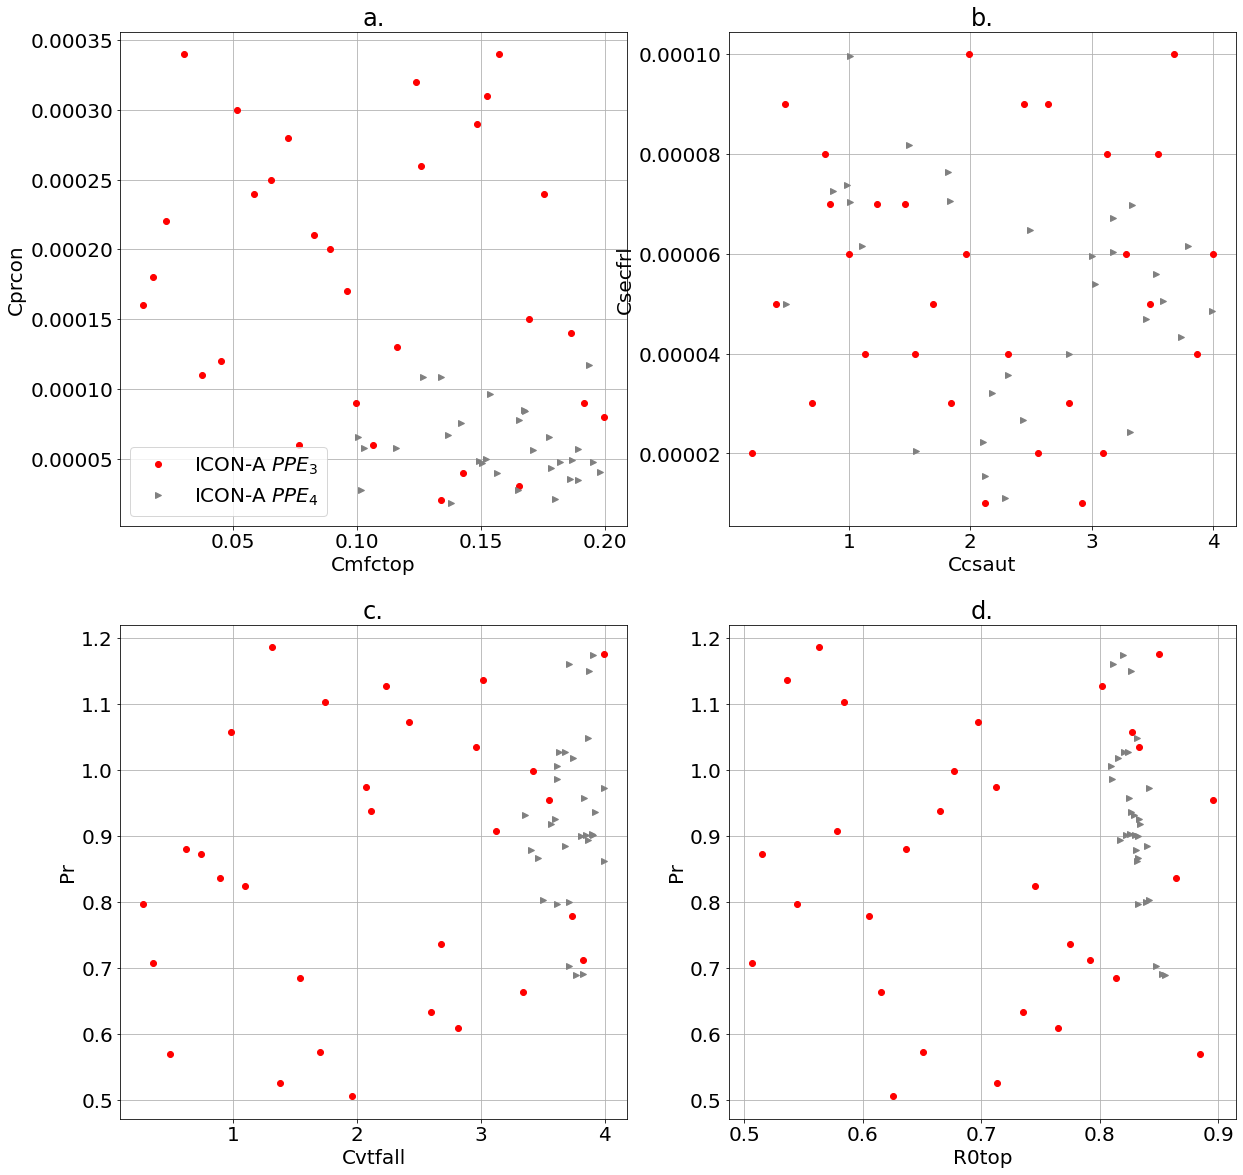

In [13]:
#show plots of parameter ranges in paper appendix
#1st and 2nd PPE

#plot parameters
labelssave=['Cmfctop', 'Cprcon', 'Ccsaut', 'Csecfrl', 'Cvtfall', 'Pr', 'R0top']
titles=['a.','b.','c.','d.']

nvar=6

fig = plt.figure()
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams["axes.labelsize"] = sizefont
plt.rcParams['figure.figsize'] = [20, 20]

iplot=1
for p1 in [0,2,4,6]:
    
    ax = fig.add_subplot(2,2,iplot)

    p2=p1+1
    if p1==6:
        p2=p1-1
    
    plt.plot(varMoreCloudParam[:,p1],varMoreCloudParam[:,p2],'or',label=name1stPPEmore)
    plt.plot(varMoreCloudParam2[:,p1],varMoreCloudParam2[:,p2],'>',color='gray',label=name2ndPPEmore)
    
    plt.title(titles[iplot-1])
    plt.xlabel(labelssave[p1])
    plt.ylabel(labelssave[p2])

    if p1==0:
        plt.legend()
    plt.grid()
    iplot+=1
#fig.savefig('PaperFig/PPE_morePhysicsParam-ParamSampling.png')

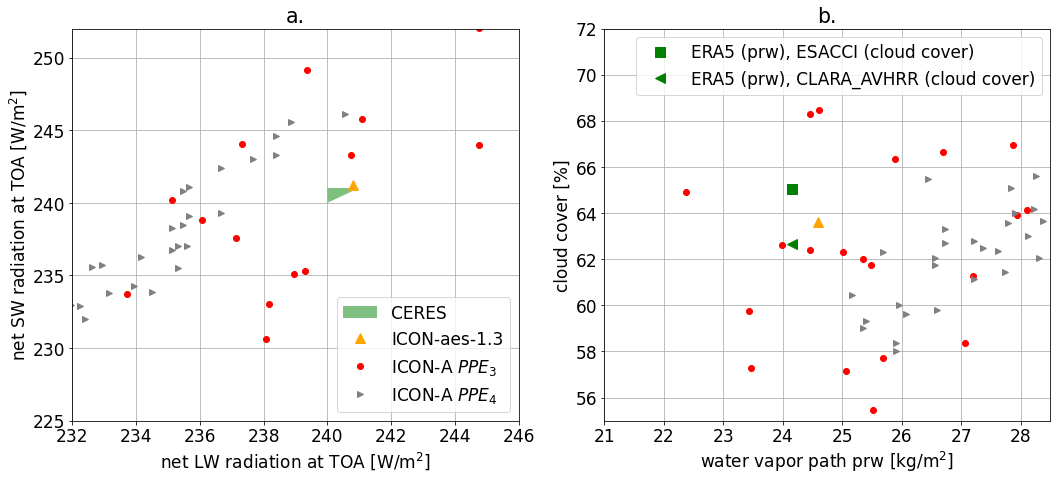

In [15]:
#Plot all Physics outputs against the Physics outputs 

cmap=plt.get_cmap("gist_rainbow")

trianglex = [ 240, 240, 241, 240 ] 
triangley = [ 240, 241, 241, 240 ]

labelsoutputs=[r'net SW radiation at TOA [W/m$^2$]',r'net LW radiation at TOA [W/m$^2$]',r'net radiation at TOA [W/m$^2$]',r'cloud cover [%]',r'water vapor path prw [kg/m$^2$]', r'global pressure at sea level [hPa]',\
                                r'tauu NAO [N/m$^2$]', r'tauu SOO [N/m$^2$]',r'ua 60N 1000hPa [m/s]',r'ua 60S 1000hPa [m/s]', r'ua 60N 10hPa [m/s]', r'ua 60S 10hPa [m/s]']
labelsoutputsnodim=[r'net SW radiation at TOA',r'net LW radiation at TOA',r'Radiative budget at TOA ',r'cloud cover',r'water vapor path prw ', r'global pressure at sea level',\
                                r'tauu NAO', r'tauu SOO',r'ua 60N 1000hPa',r'ua 60S 1000hPa', r'ua 60N 10hPa', r'ua 60S 10hPa']
FirstpartTitle='ICON PPE results,'
titles=['a.','b.']

Ntotparam=3
fig = plt.figure()
sizefont=17
plt.rc('font', size=sizefont) 
plt.rcParams["axes.labelsize"] = sizefont
plt.rcParams['figure.figsize'] = [15,7]

ax = fig.add_subplot(1,2,1)

plt.fill(trianglex, triangley,'g',alpha=0.5,label='CERES')
plt.plot([240.8], [241.2], '^',ms=10,color='orange',label='ICON-aes-1.3')
plt.plot(-resultsMoreCloudParam[:,1],resultsMoreCloudParam[:,0],'or',label=name1stPPEmore)
plt.plot(-resultsMoreCloudParam2[:,1],resultsMoreCloudParam2[:,0],'>',color='gray',label=name2ndPPEmore)

n=np.size(resultsPhyDyn_NewParam_2tun[:,1])

ax.set_title('a.')
ax.set_xlabel(r'net LW radiation at TOA [W/m$^2$]')
ax.set_ylabel(r'net SW radiation at TOA [W/m$^2$]')
ax.legend(loc="best")
ax.set_xlim([232,246])
ax.set_ylim([225,252])
ax.grid()

ax = fig.add_subplot(1,2,2)
plt.plot([24.6], [63.6], '^',ms=10,color='orange')
plt.plot(resultsMoreCloudParam[:,4],resultsMoreCloudParam[:,3],'or')
plt.plot(resultsMoreCloudParam2[:,4],resultsMoreCloudParam2[:,3],'>',color='gray')
plt.plot(ref_Prw_ERA5,ref_Clt_ESACCI,'sg',ms=10,label='ERA5 (prw), ESACCI (cloud cover)')
plt.plot(ref_Prw_ERA5,ref_Clt_CLARA_AVHRR,'<g',ms=10,label='ERA5 (prw), CLARA_AVHRR (cloud cover)')

ax.set_title('b.')
ax.set_xlabel(r'water vapor path prw [kg/m$^2$]')
ax.set_ylabel('cloud cover [%]')
ax.legend(loc="best")
ax.set_xlim([21,28.5])
ax.set_ylim([55,72])

ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig('PaperFig/Paper_PhyOutputs_MorePhyParam.png')

In [16]:
### Paper results:
##### the selected simulations are the two first ones of indplot: 4, 11 from varPhyDyn_NewParam_2tun PPE
#selected tuned runs
selectedruns=indplot[:2]

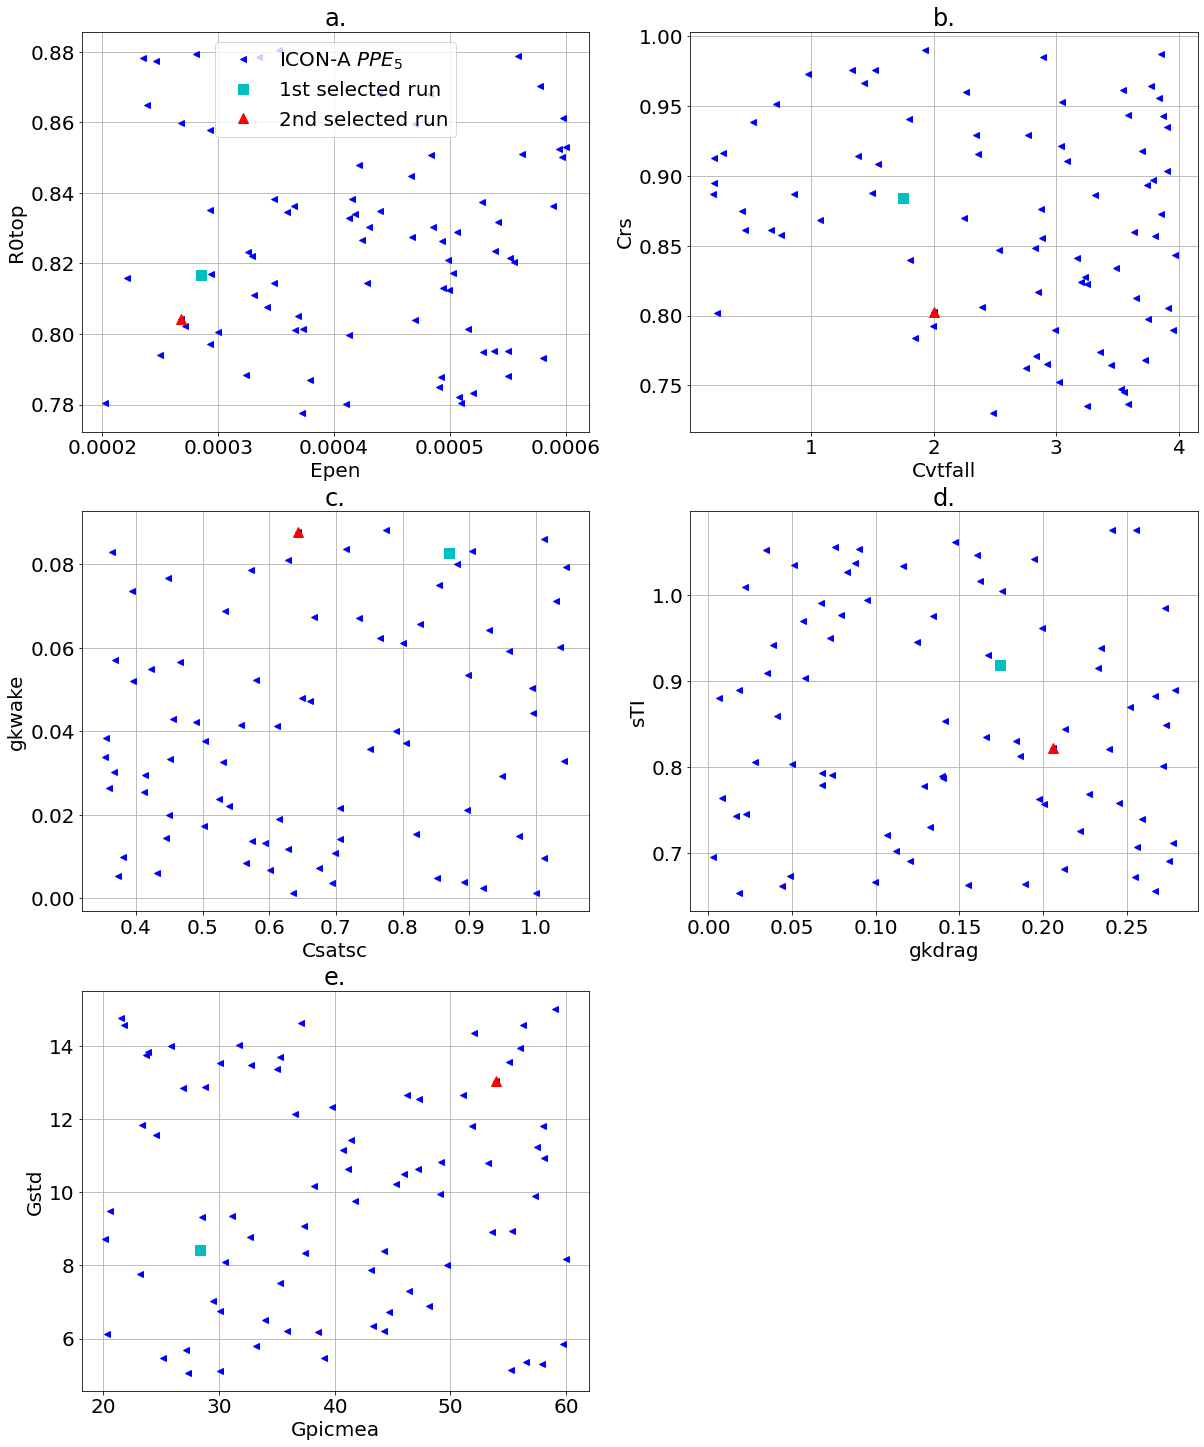

In [18]:
#show plots of parameter ranges in paper appendix
#1st and 2nd PPE
#plot parameters

col=['c','r']
lww=['s','^']
labelspoints=['1st selected run','2nd selected run']#,'3rd run']

labelssave=['Epen','R0top','Cvtfall','Crs','Csatsc','gkwake','gkdrag','sTI','Gpicmea','Gstd']#,'Emisslev']
titles=['a.','b.','c.','d.','e.']

nvar=6


fig = plt.figure()
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams["axes.labelsize"] = sizefont
plt.rcParams['figure.figsize'] = [20, 25]
iplot=1
for p1 in [0,2,4,6,8]:
    p2=p1+1
    ax = fig.add_subplot(3,2,iplot)
    
    plt.plot(varPhyDyn_NewParam_2tun[:,p1],varPhyDyn_NewParam_2tun[:,p2],'<b',label=r'ICON-A $PPE_5$')
    plt.plot(varPhyDyn_NewParam_5thPPE_2tun[:,p1],varPhyDyn_NewParam_5thPPE_2tun[:,p2],'<b')
    
    plt.title(titles[iplot-1])
    plt.xlabel(labelssave[p1])
    plt.ylabel(labelssave[p2])

    n=np.size(resultsPhyDyn_NewParam_2tun[:,1])
    ii=0
    for x in np.arange(0,n):
        if x in selectedruns:
            plt.plot(varPhyDyn_NewParam_2tun[x,p1],varPhyDyn_NewParam_2tun[x,p2],lww[ii],color=col[ii],ms=10,label=labelspoints[ii])
            ii+=1
            
    if p1==0:
        plt.legend()
    plt.grid()
    iplot+=1
#fig.savefig('PaperFig/PPE_PhyDynParam-ParamSampling.png')

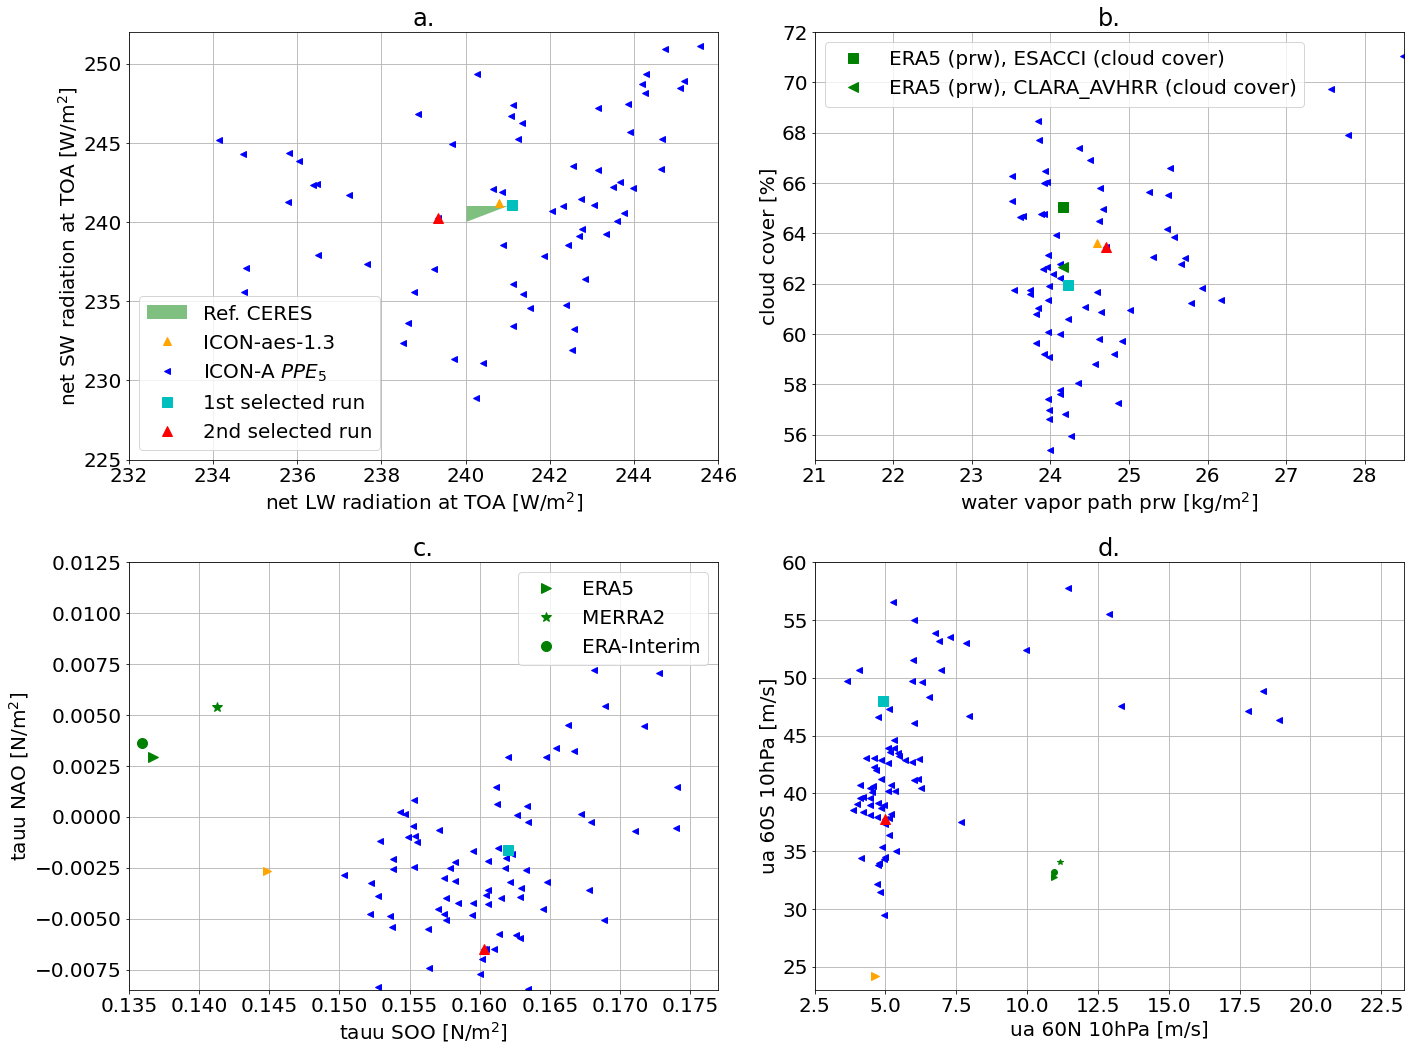

In [20]:
#Plot all Physics outputs against the Physics outputs 

cmap=plt.get_cmap("gist_rainbow")


#results=results_2ndPPE
trianglex = [ 240, 240, 241, 240 ] 
triangley = [ 240, 241, 241, 240 ]

labelsoutputs=[r'net SW radiation at TOA [W/m$^2$]',r'net LW radiation at TOA [W/m$^2$]',r'net radiation at TOA [W/m$^2$]',r'cloud cover [%]',r'water vapor path prw [kg/m$^2$]', r'global pressure at sea level [hPa]',\
                                r'tauu NAO [N/m$^2$]', r'tauu SOO [N/m$^2$]',r'ua 60N 1000hPa [m/s]',r'ua 60S 1000hPa [m/s]', r'ua 60N 10hPa [m/s]', r'ua 60S 10hPa [m/s]']
labelsoutputsnodim=[r'net SW radiation at TOA',r'net LW radiation at TOA',r'Radiative budget at TOA ',r'cloud cover',r'water vapor path prw ', r'global pressure at sea level',\
                                r'tauu NAO', r'tauu SOO',r'ua 60N 1000hPa',r'ua 60S 1000hPa', r'ua 60N 10hPa', r'ua 60S 10hPa']
FirstpartTitle='ICON PPE results,'


Ntotparam=3
fig = plt.figure()
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams["axes.labelsize"] = sizefont
plt.rcParams['figure.figsize'] = [20, 15]

ax = fig.add_subplot(2,2,1)

plt.fill(trianglex, triangley,'g',alpha=0.5,label='Ref. CERES')
plt.plot([240.8], [241.2], '^',color='orange',ms=8,label='ICON-aes-1.3')
plt.plot(-resultsPhyDyn_NewParam_2tun[:,1],resultsPhyDyn_NewParam_2tun[:,0],'<b',label=r'ICON-A $PPE_5$') #,label='ICON-A, Physics & Dyn. param. 1980-1990')
plt.plot(-results_5thPPE_2tun[:,1],results_5thPPE_2tun[:,0],'<b')#,label='ICON-A Phy Dyn param. HM')

n=np.size(resultsPhyDyn_NewParam_2tun[:,1])
ii=0
for x in np.arange(0,n):
    if x in selectedruns:
        plt.plot(-resultsPhyDyn_NewParam_2tun[x,1],resultsPhyDyn_NewParam_2tun[x,0],lww[ii],color=col[ii],ms=10,label=labelspoints[ii])
        ii+=1
ax.set_title('a.')#ICON-A PPE results, targeted reference values for TOA LW and SW radiation')
ax.set_xlabel(r'net LW radiation at TOA [W/m$^2$]')
ax.set_ylabel(r'net SW radiation at TOA [W/m$^2$]')
ax.legend(loc="best")
ax.set_xlim([232,246])
ax.set_ylim([225,252])
ax.grid()

ax = fig.add_subplot(2,2,2)
plt.plot([24.6], [63.6], '^',ms=8,color='orange')#,label='ICON-aes-1.3')
plt.plot(resultsPhyDyn_NewParam_2tun[:,4],resultsPhyDyn_NewParam_2tun[:,3],'<b') #,label='ICON-A, Physics & Dyn. param. 1980-1990')
plt.plot(results_5thPPE_2tun[:,4],results_5thPPE_2tun[:,3],'<b') #,label='ICON-A PhyDyn 4th PPE')
Ns=1

plt.plot(ref_Prw_ERA5,ref_Clt_ESACCI,'sg',ms=10,label='ERA5 (prw), ESACCI (cloud cover)')
plt.plot(ref_Prw_ERA5,ref_Clt_CLARA_AVHRR,'<g',ms=10,label='ERA5 (prw), CLARA_AVHRR (cloud cover)')

ii=0
for x in np.arange(0,n):
    if x in selectedruns:
        plt.plot(resultsPhyDyn_NewParam_2tun[x,4],resultsPhyDyn_NewParam_2tun[x,3],lww[ii],color=col[ii],ms=10)#,label='ICON-A Dynamics param., 1980-1990')
        ii+=1

ax.set_title('b.')#ICON-A PPE results, targeted reference values for Cloud Cover and water vapor path')
ax.set_xlabel(r'water vapor path prw [kg/m$^2$]')
ax.set_ylabel('cloud cover [%]')
ax.legend(loc="best")
ax.set_xlim([21,28.5])
ax.set_ylim([55,72])
plt.grid()


ax = fig.add_subplot(2,2,3)
plt.plot(aes_SOO_tauu,aes_NAO_tauu,'>',ms=8,color='orange')
plt.plot(refsERA5[3],refsERA5[2],'>g',ms=10, label='ERA5')
plt.plot(refsMERRA2[3],refsMERRA2[2],'*g',ms=10, label='MERRA2')
plt.plot(refsERAInterim[3],refsERAInterim[2],'og',ms=10, label='ERA-Interim')
plt.plot(resultsPhyDyn_NewParam_2tun[:,7],resultsPhyDyn_NewParam_2tun[:,6],'<b')
plt.plot((results_5thPPE_2tun[:,7]),(results_5thPPE_2tun[:,6]),'<b')
ii=0
for x in np.arange(0,n):
    if x in selectedruns:
        plt.plot(resultsPhyDyn_NewParam_2tun[x,7],resultsPhyDyn_NewParam_2tun[x,6],lww[ii],color=col[ii],ms=10)
        ii+=1
    
ax.set_title('c.')
ax.set_xlabel(labelsoutputs[7])
ax.set_ylabel(labelsoutputs[6])
plt.xlim([0.135,0.177])
plt.ylim([-0.0085,0.0125])
plt.legend()
plt.grid()

ax = fig.add_subplot(2,2,4)
plt.plot(refsERA5[0],refsERA5[1], '>g')
plt.plot(refsMERRA2[0],refsMERRA2[1], '*g')
plt.plot(refsERAInterim[0],refsERAInterim[1],'og')

plt.plot(aes_60N_10hPa_ua,aes_60S_10hPa_ua,'>',ms=8,color='orange')

plt.plot(resultsPhyDyn_NewParam_2tun[:,10],resultsPhyDyn_NewParam_2tun[:,11],'<b')
plt.plot((results_5thPPE_2tun[:,10]),(results_5thPPE_2tun[:,11]),'<b')

ii=0
for x in np.arange(0,n):
    if x in selectedruns:
        plt.plot(resultsPhyDyn_NewParam_2tun[x,10],resultsPhyDyn_NewParam_2tun[x,11],lww[ii],color=col[ii],ms=10)
        ii+=1
    
ax.set_title('d.')
ax.set_xlabel(labelsoutputs[10])
ax.set_ylabel(labelsoutputs[11])
plt.xlim([2.5,23.3])
plt.ylim([23,60])

ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig('PaperFig/Paper_PhyDynOutputs_PhyDynParam.png')

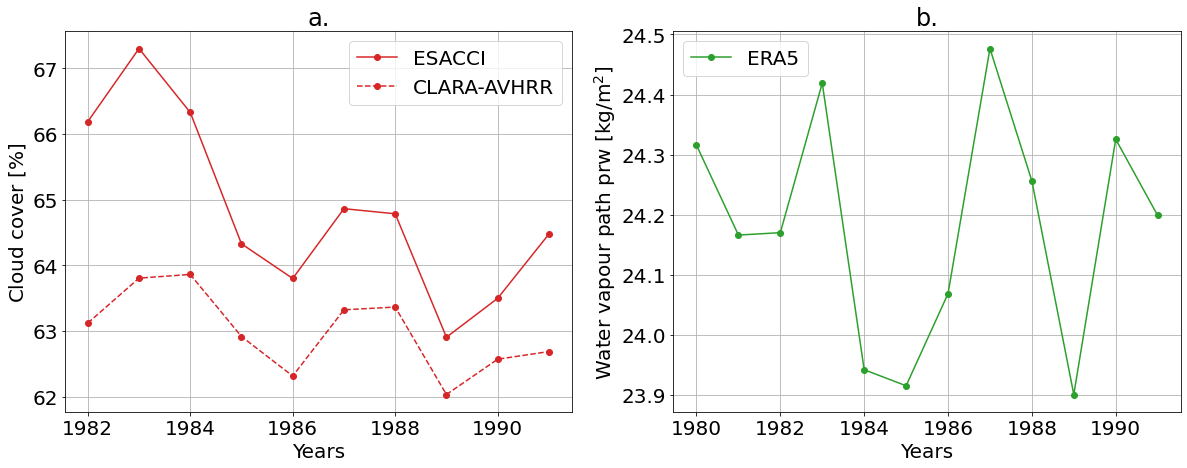

In [22]:
plt.rcParams['figure.figsize'] = [20, 7]
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams["axes.labelsize"] = sizefont
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
color = 'tab:red'
ax1.set_xlabel('Years') 
ax1.set_ylabel(r'Cloud cover [$\%$]')#, color = color) 
ax1.plot(years_clt_esacci, clt_esacci_per_year, 'o-', color = color,label="ESACCI")
ax1.plot(years_clt_claraavhrr, clt_claraavhrr_per_year, 'o--',color = color,label="CLARA-AVHRR")
ax1.legend(loc='upper right')
ax1.set_title('a.')
ax1.tick_params(axis ='y')#, labelcolor = color) 
ax1.grid(True)  
# Adding Twin Axes to plot using dataset_2

ax2 = fig.add_subplot(1,2,2) 
color = 'tab:green'
ax2.set_xlabel('Years') 
ax2.set_ylabel('Water vapour path prw [kg/m$^2$]')#, color = color) 
ax2.plot(years_prw_era5, prw_era5_per_year,'o-', color = color,label='ERA5') 
ax2.tick_params(axis ='y')#, labelcolor = color) 
ax2.legend(loc='upper left')
ax2.set_title('b.')
ax2.grid(True) 
#fig.savefig('PaperFig/Paper_Observations_Clt_Prw_per_year.png')